In [2]:
import nltk
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch
from fastai import *
from fastai.vision import *


#processing tokens
import unicodedata 
import re
import inflect 

#tokenize
from nltk import word_tokenize, sent_tokenize

#find ngrams
from nltk.util import ngrams

import time

In [9]:
file = open("../corpus/bible.txt").read()

In [10]:
start = time.time()
sentences = sent_tokenize(file)
tokenised_sentences = []
tokens = word_tokenize(file)

# now loop over each sentence and tokenize it separately
for sentence in sentences:
    tokenised_sentences.append(word_tokenize(sentence))

end = time.time()
print(end-start)

8.093530654907227


In [11]:
#normalise tokens manually

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words


def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    #words = remove_stopwords(words)
    return words

start = time.time()
data_sen = []

for x in range(len(tokenised_sentences)):
    data_sen.append(normalize(tokenised_sentences[x]))

data_tokens = normalize(tokens)
    
end = time.time()

print(end-start)

2.301909923553467


In [12]:
print(data_sen[:5])
print(data_tokens[:10])

[['in', 'the', 'beginning', 'god', 'created', 'the', 'heaven', 'and', 'the', 'earth'], ['and', 'the', 'earth', 'was', 'without', 'form', 'and', 'void', 'and', 'darkness', 'was', 'upon', 'the', 'face', 'of', 'the', 'deep'], ['and', 'the', 'spirit', 'of', 'god', 'moved', 'upon', 'the', 'face', 'of', 'the', 'waters'], ['and', 'god', 'said', 'let', 'there', 'be', 'light', 'and', 'there', 'was', 'light'], ['and', 'god', 'saw', 'the', 'light', 'that', 'it', 'was', 'good', 'and', 'god', 'divided', 'the', 'light', 'from', 'the', 'darkness']]
['in', 'the', 'beginning', 'god', 'created', 'the', 'heaven', 'and', 'the', 'earth']


In [13]:
trigrams = ngrams(data_tokens, 3)
tg_list = list(trigrams)

In [14]:
print(list(trigrams)[:10])

[]


In [15]:
print(tg_list[0])

('in', 'the', 'beginning')


In [16]:
fd = nltk.FreqDist(tg_list)

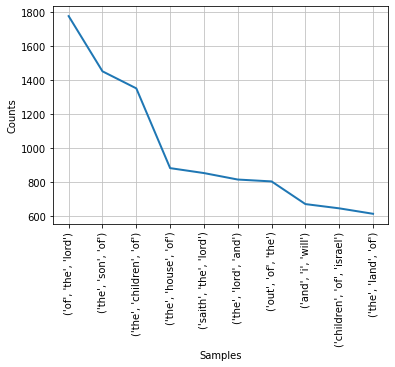

[(('of', 'the', 'lord'), 1775),
 (('the', 'son', 'of'), 1451),
 (('the', 'children', 'of'), 1351),
 (('the', 'house', 'of'), 883),
 (('saith', 'the', 'lord'), 854),
 (('the', 'lord', 'and'), 816),
 (('out', 'of', 'the'), 805),
 (('and', 'i', 'will'), 672),
 (('children', 'of', 'israel'), 647),
 (('the', 'land', 'of'), 615)]

In [11]:
fd.plot(10)
fd.most_common(10)

In [12]:
for x in range(10):
    print(fd.r_Nr()[x])

#total
print(fd.N())

0
329932
48880
16864
8304
4908
3064
2110
1633
1187
791591


# WRONG

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import itertools

start = time.time()

#set() - no duplicates
#{} - dictionray, maps individual tokens to key
word_to_id = {token: idx for idx, token in enumerate(set(data_tokens))}

print(tg_list[0])

# convert token lists to token-id lists, e.g. [[1, 2], [2, 2]] here
data_tokens_ids = [[word_to_id[token] for token in trigram] for trigram in tg_list]

print(data_tokens_ids[0])
#converting back to words
for token_id in data_tokens_ids[0]:
    print(list(word_to_id)[token_id])

vec = OneHotEncoder(categories='auto')
X = vec.fit_transform(data_tokens_ids)
tg_OneHot = X.toarray()

print (tg_OneHot)
end = time.time()
print(end-start)

In [ ]:
tg_counts = [fd.freq(trigram)*fd.N() for trigram in tg_list]
tg_prob = [fd.freq(trigram) for trigram in tg_list]

#print(tg_counts)

print(tg_list[0])
#print(tg_OneHot[0])
print(tg_counts[0])
print(tg_prob[0])

# RATHER

In [ ]:
start = time.time()

#{} - dictionary, maps individual tokens to key
id_to_ngram = {idx: ngram for idx, ngram in enumerate(tg_list)}
ngram_to_id = {ngram: idx for idx, ngram in enumerate(tg_list)}

no_tg = fd.N()

frequencies = [fd.freq(id_to_ngram[x]) for x in range(no_tg)]
ngram_freq = np.identity(no_tg)*frequencies

print(ngram_freq)

end = time.time()
print(end-start)

# Neural Net



In [3]:
import torch.nn as nn
from torch import optim
from sklearn import preprocessing

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc3 = nn.Linear(3, 1)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc3(x)) 
        return x

# Creating Fast Ai Dataset

In [16]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, total): #[1 , 3] dimension
        self.x = x
        self.y = torch.zeros(len(x),dtype = torch.float)
        for i in range(len(x)):
            #self.y[i] = (x[i][2]*x[i][1])
            self.y[i] = (x[i][0]*x[i][1])
                        
        self.c = 1 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]


# data

In [17]:
inputs = torch.zeros(10,2, dtype = torch.float)
total = fd.N()
target = torch.zeros(len(inputs))

for x in range(10): #x starts at zero
    '''
    r = x+1               #count
    Cr = fd.r_Nr()[x+1]   #number of ngrams appearing r times
    Cr2 = fd.r_Nr()[x+2]  #number of ngrams appearing r + 1 times
    C = Cr2/Cr            #ratio of Cr+1/Cr
    
    inputs[x][0] = r/10
    inputs[x][1] = C
    inputs[x][2] = (r+1)/total
    
    target[i] = (train[i][2])*(train[i][1])
    '''
    
    r = x+1               #count
    Cr = fd.r_Nr()[x+1]   #number of ngrams appearing r times
    Cr2 = fd.r_Nr()[x+2]  #number of ngrams appearing r + 1 times
    C = Cr2/Cr           #ratio of Cr+1/Cr
    
    inputs[x][0] = C        #ratio
    inputs[x][1] = (r+1)/10 #count
    
    target[x] = (inputs[x][0])*(inputs[x][1])
    
print(inputs)
print(target)    

tensor([[0.1482, 0.2000],
        [0.3450, 0.3000],
        [0.4924, 0.4000],
        [0.5910, 0.5000],
        [0.6243, 0.6000],
        [0.6886, 0.7000],
        [0.7739, 0.8000],
        [0.7269, 0.9000],
        [0.7725, 1.0000],
        [0.8571, 1.1000]])
tensor([0.0296, 0.1035, 0.1970, 0.2955, 0.3746, 0.4820, 0.6191, 0.6542, 0.7725,
        0.9429])


# For FastAI

In [18]:
train = inputs
rand = torch.ones(2, dtype = torch.float).uniform_(0.7,1)
valid = (inputs*rand)
train = train.float()

print(train)
print(valid)

tensor([[0.1482, 0.2000],
        [0.3450, 0.3000],
        [0.4924, 0.4000],
        [0.5910, 0.5000],
        [0.6243, 0.6000],
        [0.6886, 0.7000],
        [0.7739, 0.8000],
        [0.7269, 0.9000],
        [0.7725, 1.0000],
        [0.8571, 1.1000]])
tensor([[0.1243, 0.1974],
        [0.2895, 0.2962],
        [0.4131, 0.3949],
        [0.4959, 0.4936],
        [0.5238, 0.5923],
        [0.5778, 0.6910],
        [0.6493, 0.7897],
        [0.6098, 0.8885],
        [0.6481, 0.9872],
        [0.7191, 1.0859]])


In [19]:
train_ds, valid_ds = ArrayDataset(train,total), ArrayDataset(valid,total)
data = DataBunch.create(train_ds, valid_ds, bs=2)
print(data.one_batch())

print(total)

(tensor([[0.3450, 0.3000],
        [0.7739, 0.8000]]), tensor([0.1035, 0.6191]))
791591


# Manual Training

In [304]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.1)
#criterion = torch.nn.SmoothL1Loss()
criterion = torch.nn.L1Loss()

In [305]:
start = time.time()

for epoch in range(1, 1000): ## run the model for 10 epochs

    for x in range(len(train)): #x starts at zero
           
        #print(inputs)
        #print(inputs.dtype)

        optimizer.zero_grad()
        
        ## 1. forward propagation
        net_out = net(train[x])
        #print(train[x])
        
        ## 2. loss calculation
        loss = criterion(net_out, target[x])
        #print(target[x])
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
    if(epoch % 100 == 1):
        print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, 
            loss.data))

end = time.time()
print(end-start)

Train Epoch: 1 	Loss: 0.454285
Train Epoch: 101 	Loss: 0.092396
Train Epoch: 201 	Loss: 0.087956
Train Epoch: 301 	Loss: 0.108106
Train Epoch: 401 	Loss: 0.089450
Train Epoch: 501 	Loss: 0.100716
Train Epoch: 601 	Loss: 0.091644
Train Epoch: 701 	Loss: 0.091004
Train Epoch: 801 	Loss: 0.102009
Train Epoch: 901 	Loss: 0.083409
3.7685515880584717


# Fast AI equivalent

helps visualise learning curve

In [300]:
#criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()
#criterion = torch.nn.SmoothL1Loss()
net2 = Net().cuda()

In [301]:
learn = Learner(data, net2, opt_func = torch.optim.SGD, loss_func = criterion)

In [302]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


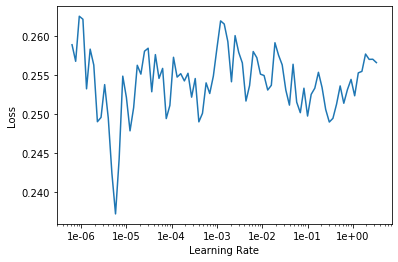

In [303]:
learn.recorder.plot()

In [176]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.264493,0.136706,00:00


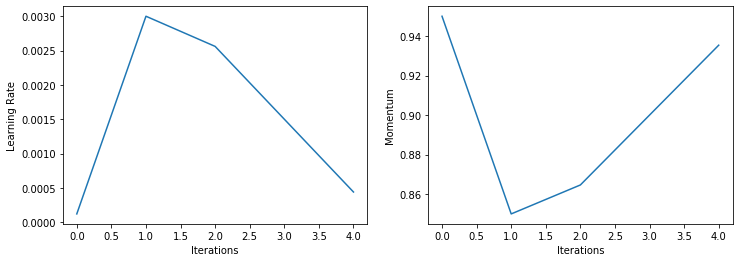

In [177]:
learn.recorder.plot_lr(show_moms=True)

# Saving model

In [310]:
torch.save(net.state_dict(), 'save/29_07')

# Loading model

In [5]:
net = Net()
net.load_state_dict(torch.load('save/28_07'))
net.eval()

Net(
  (fc1): Linear(in_features=2, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)

# Result

## manual training

In [6]:
print(net(torch.Tensor([1, 0]))) #ratio, count

tensor([0.1106], grad_fn=<SigmoidBackward>)


/home/werner/.local/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
x = torch.Tensor(20,2)
y = torch.Tensor(20)

for i in range (20):
    x[i] = torch.Tensor([(i/20), 0])
    y[i] = net(x[i])/total
    
print(y)

tensor([2.5699e-08, 2.7336e-08, 2.9076e-08, 3.0924e-08, 3.3303e-08, 3.6536e-08,
        4.0072e-08, 4.3937e-08, 4.8161e-08, 5.2774e-08, 5.7807e-08, 6.3295e-08,
        6.9275e-08, 7.5783e-08, 8.2861e-08, 9.0549e-08, 9.8890e-08, 1.0793e-07,
        1.1771e-07, 1.2828e-07], grad_fn=<CopySlices>)


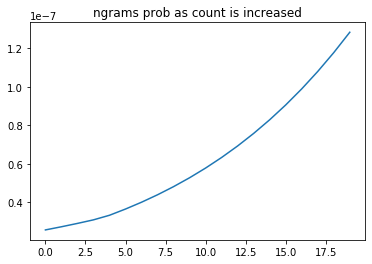

In [19]:
plt.plot(y)
plt.title("ngrams prob as count is increased")
plt.show()

given total of 1000 ngrams and occurence for this ngram to be 10

In [40]:
x = torch.Tensor(20,2)
y = torch.Tensor(20)

for i in range (20):
    x[i] = torch.Tensor([0,(i/20)])
    y[i] = net(x[i])

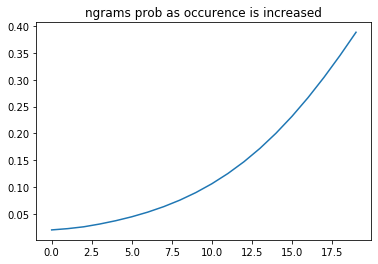

In [41]:
plt.plot(y)
plt.title("ngrams prob as occurence is increased")
plt.show()

given total of 1000 ngrams and count of ngram be 50

# Good Turing NLTK library


In [45]:
from nltk.probability import SimpleGoodTuringProbDist as GT
gtfd = GT(fd)

In [46]:
#counts for x freq
print(fd.r_Nr()[0])
print(fd.r_Nr()[1])
print(fd.r_Nr()[2])
print(fd.r_Nr()[3])
print(fd.r_Nr()[4])
#total
print(fd.N())

0
329932
48880
16864
8304
791591


In [47]:
print(fd.r_Nr()[1]/fd.N()) #prob of unseen ngram according to good turing

0.4167960474537987


In [49]:
print(fd.freq(('of', 'the', 'lord')))
print(gtfd.prob(('of', 'the', 'lord')))

0.0022423195817031774
0.002247129762164356


In [84]:
print(net(torch.Tensor([1, 0.1]))/fd.N()) #ratio, count

tensor([1.9305e-07], grad_fn=<DivBackward0>)


In [85]:
#print(len(gtfd.samples()))
#print(list(gtfd.freqdist())[424144])

print(fd.freq(('even', 'so', 'come')))
print(gtfd.prob(('even', 'so', 'come')))

1.2632786375792549e-06
3.7542445852511763e-07
